In [1]:
pacman::p_load("tidyverse","readxl","vcfR","VariantAnnotation","rtracklayer",
               "Biostrings","Rsamtools","plyranges","glue","patchwork","xlsx")


In [2]:
sknsh_df = read_delim("../../data/mpra_validation/MPRAmodel_SCZ_only_SKNSH_SKNSH_emVAR_glm_20231201.out")

sknsh_df = sknsh_df %>% mutate(sample_id = str_split(ID,":",simplify=TRUE)[,2],
                   Dx = str_split(sample_id,"_",simplify=TRUE)[,4],
                   sample_id = str_c(str_split(sample_id,"_",simplify=TRUE)[,1], "_",
                                     str_split(sample_id,"_",simplify=TRUE)[,2], "_",
                                     str_split(sample_id,"_",simplify=TRUE)[,3])) %>%
    mutate(is_emVar = ifelse(Skew_logFDR_act > -log10(0.05),"Yes","No")) %>%
    filter(sample_id != "CMC_MSSM_224") # remove outlier

head(sknsh_df)


Rows: 9804 Columns: 31
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (9): ID, comb, SNP, chr, ref_allele, alt_allele, allele, window, strand
dbl (21): pos, A_Ctrl_Mean, A_Exp_Mean, A_log2FC, A_log2FC_SE, A_logP, A_log...
lgl  (1): haplotype

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ID,comb,SNP,chr,pos,ref_allele,alt_allele,allele,window,strand,⋯,B_logPadj_BF,Log2Skew,Skew_SE,skewStat,Skew_logP,Skew_logFDR,Skew_logFDR_act,sample_id,Dx,is_emVar
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
schizophrenia:CMC_MSSM_027_SCZ_1:11973569:C:T:left:ref,1_11973569_C_T_left_fwd_NA,1_11973569_C_T,1,11973569,C,T,ref,left,fwd,⋯,21.243832,-0.28056699,0.06390580,-4.39032106,4.94621719,3.82287025,4.09037020,CMC_MSSM_027,SCZ,Yes
schizophrenia:CMC_MSSM_027_SCZ_1:11973569:C:T:middle:ref,1_11973569_C_T_middle_fwd_NA,1_11973569_C_T,1,11973569,C,T,ref,middle,fwd,⋯,95.479338,-0.42064368,0.07429658,-5.66168261,7.82421032,6.51223491,6.78623172,CMC_MSSM_027,SCZ,Yes
schizophrenia:CMC_MSSM_027_SCZ_1:11973569:C:T:right:ref,1_11973569_C_T_right_fwd_NA,1_11973569_C_T,1,11973569,C,T,ref,right,fwd,⋯,3.805662,-0.29305172,0.12711856,-2.30534166,1.67474207,1.04863951,1.23905150,CMC_MSSM_027,SCZ,No
schizophrenia:CMC_MSSM_027_SCZ_1:182008461:C:T:left:ref,1_182008461_C_T_left_fwd_NA,1_182008461_C_T,1,182008461,C,T,ref,left,fwd,⋯,11.354754,0.07385524,0.13625601,0.54203289,0.23077349,0.10500707,0.14122018,CMC_MSSM_027,SCZ,No
schizophrenia:CMC_MSSM_027_SCZ_1:182008461:C:T:middle:ref,1_182008461_C_T_middle_fwd_NA,1_182008461_C_T,1,182008461,C,T,ref,middle,fwd,⋯,0.000000,-0.24425317,0.11209103,-2.17906077,1.53273008,0.94238250,1.12271084,CMC_MSSM_027,SCZ,No
schizophrenia:CMC_MSSM_027_SCZ_1:182008461:C:T:right:ref,1_182008461_C_T_right_fwd_NA,1_182008461_C_T,1,182008461,C,T,ref,right,fwd,⋯,0.000000,0.01103567,0.12144437,0.09087018,0.03264125,0.01443148,0.01974467,CMC_MSSM_027,SCZ,No


Warning message:
“Removed 1462 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1462 rows containing missing values (`geom_point()`).”


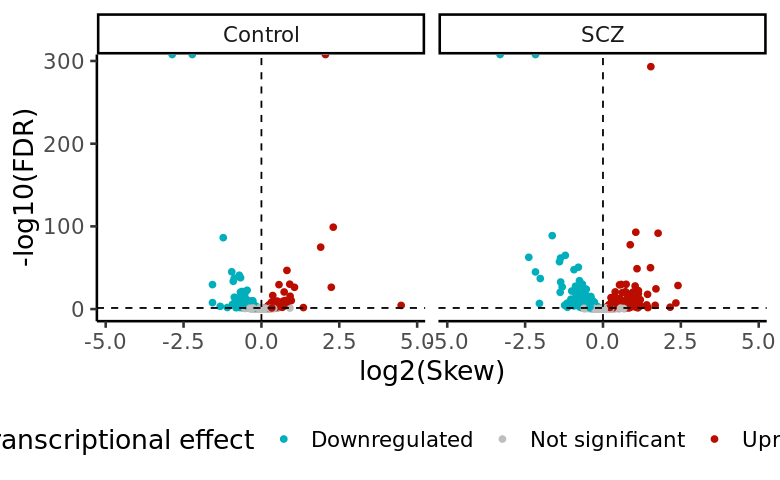

In [3]:
## Plotting volcano plot
options(repr.plot.width=6.5, repr.plot.height=4)
p1 = sknsh_df %>% mutate(diffexp= "NO") %>% filter(window == "middle") %>%
    mutate(diffexp = ifelse(Log2Skew > 0 & Skew_logFDR_act > -log10(0.05),"UP",diffexp)) %>%
    mutate(diffexp = ifelse(Log2Skew <0 & Skew_logFDR_act > -log10(0.05), "DOWN",diffexp)) %>%
    ggplot(aes(x= Log2Skew, y= Skew_logFDR_act)) + geom_point(aes(color=diffexp)) +
    theme_classic(16) +
    geom_hline(yintercept = -log10(0.05),col = "black", lty='dashed') +
    geom_vline(xintercept = 0, col="black",lty="dashed") +
    labs(y="-log10(FDR)",x="log2(Skew)" ,color="sSNV transcriptional effect") +
    scale_color_manual(values = c("#00AFBB","grey","#bb0c00"), 
                      labels = c("Downregulated","Not significant","Upregulated")) +
    facet_wrap(~Dx,ncol = 2) +
    theme(legend.position = "bottom")
    
p1
ggsave("../../figures/volcano_mpra.pdf",p1,device="pdf", width=6.5,height=4)

In [4]:
## Calculate the fraction of activating vs downregulating variants
sknsh_df %>% filter(is_emVar=="Yes", window=="middle") %>% dplyr::count(Dx, Log2Skew >0)


Dx,Log2Skew > 0,n
<chr>,<lgl>,<int>
Control,FALSE,96
Control,TRUE,73
SCZ,FALSE,196
SCZ,TRUE,210


In [5]:
sknsh_df %>% filter(chr=="19",pos==11593076)

ID,comb,SNP,chr,pos,ref_allele,alt_allele,allele,window,strand,⋯,B_logPadj_BF,Log2Skew,Skew_SE,skewStat,Skew_logP,Skew_logFDR,Skew_logFDR_act,sample_id,Dx,is_emVar
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
schizophrenia:CMC_MSSM_254_SCZ_19:11593076:A:C:left:ref,19_11593076_A_C_left_fwd_NA,19_11593076_A_C,19,11593076,A,C,ref,left,fwd,⋯,232.4455,-0.4962201,0.05127829,-9.677002,21.42294,19.68195,19.95777,CMC_MSSM_254,SCZ,Yes
schizophrenia:CMC_MSSM_254_SCZ_19:11593076:A:C:middle:ref,19_11593076_A_C_middle_fwd_NA,19_11593076_A_C,19,11593076,A,C,ref,middle,fwd,⋯,301.8385,-0.5661674,0.05309542,-10.663206,25.82019,23.98715,24.26296,CMC_MSSM_254,SCZ,Yes
schizophrenia:CMC_MSSM_254_SCZ_19:11593076:A:C:right:ref,19_11593076_A_C_right_fwd_NA,19_11593076_A_C,19,11593076,A,C,ref,right,fwd,⋯,301.8385,-0.4259123,0.04561604,-9.336898,20.00350,18.30876,18.58458,CMC_MSSM_254,SCZ,Yes


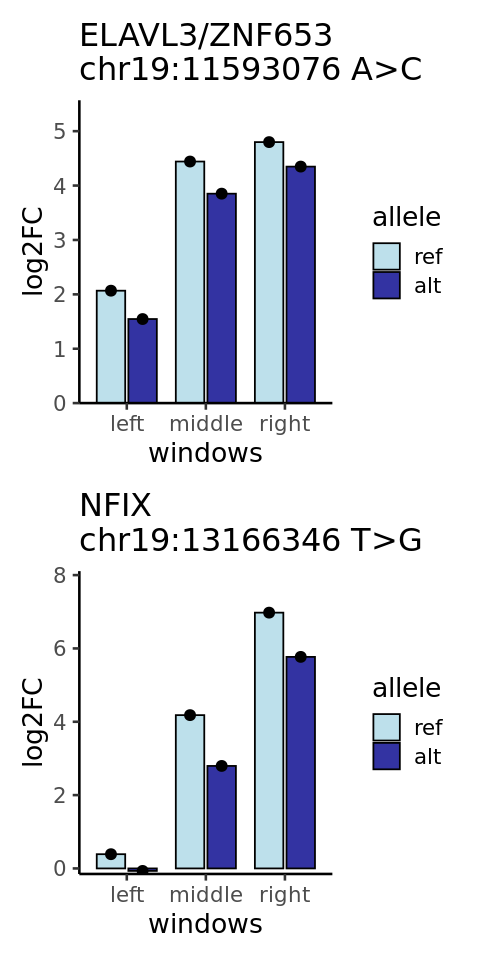

In [6]:
## Plotting effect of variants

options(repr.plot.width=4, repr.plot.height=4)


# ## ELVAVL3
gene = "ELAVL3/ZNF653"
tmp = sknsh_df %>% filter(chr=="19",pos==11593076) %>% 
    dplyr::select(A_log2FC,B_log2FC, A_log2FC_SE, B_log2FC_SE, Skew_logFDR,chr,pos,ref_allele,alt_allele, window) 
tmp_df = data.frame(allele=factor(rep(c("ref","alt"),each=3),levels=c("ref","alt")), log2FC = c(tmp$A_log2FC,tmp$B_log2FC),
                   SE=c(tmp$A_log2FC_SE,tmp$B_log2FC_SE), windows = rep(c("left","middle","right"),2))
p1 = tmp_df %>% ggplot(aes(x=windows,y=log2FC)) +
    geom_bar(aes(fill=allele),stat="identity",color="black", alpha=0.8, width=0.8,position=position_dodge2()) +
    geom_pointrange(aes(ymin= log2FC - SE, ymax=log2FC+ SE),color="black",position=position_dodge2(width=0.8)) +
    theme_classic(16) +
    scale_fill_manual(values=c("lightblue","darkblue")) +
    labs(title=paste0(gene,"\n",paste0("chr",tmp$chr,":",tmp$pos," ",tmp$ref_allele,">",tmp$alt_allele))) +
#     geom_text(x= 1.5,y=max(tmp_df$log2FC)+0.3,label=paste("log10 FDR = ",round(tmp$Skew_logFDR,2))) +
    scale_y_continuous(expand = expansion(mult = c(0, 0.15))) 



## NFIX
gene = "NFIX"
tmp = sknsh_df %>% filter(chr=="19", pos==13166346) %>%
    dplyr::select(A_log2FC,B_log2FC, A_log2FC_SE, B_log2FC_SE, Skew_logFDR,chr,pos,ref_allele,alt_allele, window) 
tmp_df = data.frame(allele=factor(rep(c("ref","alt"),each=3),levels=c("ref","alt")), log2FC = c(tmp$A_log2FC,tmp$B_log2FC),
                   SE=c(tmp$A_log2FC_SE,tmp$B_log2FC_SE), windows = rep(c("left","middle","right"),2))
p2 = tmp_df %>% ggplot(aes(x=windows,y=log2FC)) +
    geom_bar(aes(fill=allele),stat="identity",color="black", alpha=0.8, width=0.8,position=position_dodge2()) +
    geom_pointrange(aes(ymin= log2FC - SE, ymax=log2FC+ SE),color="black",position=position_dodge2(width=0.8)) +
    theme_classic(16) +
    scale_fill_manual(values=c("lightblue","darkblue")) +
    labs(title=paste0(gene,"\n",paste0("chr",tmp$chr,":",tmp$pos," ",tmp$ref_allele,">",tmp$alt_allele))) +
#     geom_text(x= 1.5,y=max(tmp_df$log2FC)+0.3,label=paste("log10 FDR = ",round(tmp$Skew_logFDR,2))) +
    scale_y_continuous(expand = expansion(mult = c(0, 0.15)))


options(repr.plot.width=4, repr.plot.height=8)
p3 = p1 / p2
p3
ggsave("../../figures/mpra_genes.pdf",p3,device="pdf",height=8,width=4)


    


In [7]:
## Base changes in emVars

boot_fisher <- function(data_gr, fwd, bwd, is_cg, B,to_plot){
    
    if(is_cg == "yes"){
        data_gr = data_gr %>% filter((data_gr$Mutation == fwd & data_gr$dn %in% plus_cg) | (data_gr$Mutation == bwd & data_gr$dn %in% neg_cg))
    } else if(is_cg == "no"){
        data_gr = data_gr %>% filter((data_gr$Mutation == fwd & !(data_gr$dn %in% plus_cg))| (data_gr$Mutation == bwd & !(data_gr$dn %in% neg_cg)))
    } else{
        data_gr = data_gr %>% filter((data_gr$Mutation == fwd) | (data_gr$Mutation == bwd))
    }
    
    
    test1 = fisher.test(table(data_gr$is_emVar,data_gr$Dx))
    test_df = parallel::mclapply(1:B, function(x){
        boot_dx = sample(data_gr$Dx, replace=FALSE)
        boot_var = data_gr$is_emVar
        boot_test = fisher.test(table(boot_var, boot_dx))
        res = data.frame(OR = boot_test$estimate, pval=boot_test$p.value)
    })
    
    test_df = do.call(rbind, test_df)
    if (test1$estimate <1){
        # if OR < 1, we want to check whether there is a value less than the one we observed
        pval = 2*sum(test1$estimate > test_df$OR)/B
        message(paste(paste(fwd,"permutated p-value ="),pval ))
    } else{
        # if OR >= 1, then we look for extremity on the other direction
        pval = 2*sum(test1$estimate < test_df$OR)/B
        message(paste(paste(fwd,"permutated p-value ="),pval))
    }
    print(test1)
    if (to_plot){
        test_df %>%
        ggplot(aes(x = -log10((rank(pval, ties.method="first")+0.5)/(nrow(test_df)+1)),y=-log10(pval))) +
        geom_point(alpha=0.5)+ 
        geom_abline(slope=1, color="red") + 
        labs(x= "-log10 Theoretical Uniform Quantiles",y= "-log10 Observed p-values") +
        theme_classic(16)
    }
    
    return(data.frame(OR = log2(test1$estimate), p=pval))
}



C/A permutated p-value = 0.3356




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 0.4204
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.405828 1.548470
sample estimates:
odds ratio 
 0.7818541 



C/G permutated p-value = 0.6812




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.3214493 3.1259324
sample estimates:
odds ratio 
 0.9357958 



C/T permutated p-value = 0.214




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 0.2415
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.6477414 1.1215177
sample estimates:
odds ratio 
 0.8506637 



T/A permutated p-value = 0.1362




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 0.2484
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.6343609 6.8731502
sample estimates:
odds ratio 
  1.893641 



T/C permutated p-value = 0.3654




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 0.5979
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.6135602 3.0557070
sample estimates:
odds ratio 
  1.310639 



T/G permutated p-value = 0.5834




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 0.8399
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.494571 3.091188
sample estimates:
odds ratio 
  1.168612 



C/A permutated p-value = 0.716




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 0.8763
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4967088 1.8403835
sample estimates:
odds ratio 
 0.9412149 



C/G permutated p-value = 0.4252




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 0.6412
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4685158 4.3419262
sample estimates:
odds ratio 
  1.325418 



C/T permutated p-value = 0.0352




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 0.04603
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.5915811 0.9995709
sample estimates:
odds ratio 
 0.7679071 



T/A permutated p-value = 0.235




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 0.4047
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.6056628 4.2495246
sample estimates:
odds ratio 
  1.528972 



T/C permutated p-value = 0.724




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.5582582 2.1483280
sample estimates:
odds ratio 
  1.068694 



T/G permutated p-value = 0.0296




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 0.09393
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.8906034 10.5865886
sample estimates:
odds ratio 
  2.631457 



C/A permutated p-value = 0.4386




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 0.5399
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4443205 1.5823769
sample estimates:
odds ratio 
 0.8281633 



C/G permutated p-value = 0.6206




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4212835 3.4618894
sample estimates:
odds ratio 
  1.141888 



C/T permutated p-value = 0.189




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 0.224
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.9043605 1.5342132
sample estimates:
odds ratio 
  1.175185 



T/A permutated p-value = 0.372




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 0.6342
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4826037 4.5688935
sample estimates:
odds ratio 
  1.385807 



T/C permutated p-value = 0.3924




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 0.5587
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.6641011 2.4123891
sample estimates:
odds ratio 
    1.2361 



T/G permutated p-value = 0.0446




	Fisher's Exact Test for Count Data

data:  table(data_gr$is_emVar, data_gr$Dx)
p-value = 0.1237
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.860147 6.607208
sample estimates:
odds ratio 
  2.180748 



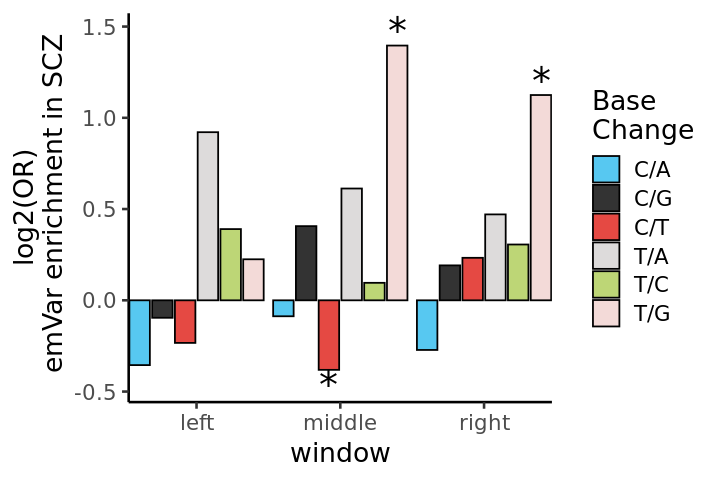

In [8]:
plus_cg = c("ACG","CCG","GCG","TCG")
neg_cg = c("CGA","CGC","CGG","CGT")
fwd_list = c("C/A","C/G","C/T","T/A","T/C","T/G")
bwd_list = c("G/T","G/C","G/A","A/T","A/G","A/C")
windows= c("left","middle","right")

## Calculate the enrichment of emVars in cases vs controls of emVars at different base changes
## No CpG consideration

sknsh_df = sknsh_df %>% mutate(is_emVar = ifelse(is.na(is_emVar),"No",is_emVar)) 

set.seed(1234)
full_res = lapply(1:length(windows),function(i){
    data_i = sknsh_df %>% mutate(Mutation = glue("{ref_allele}/{alt_allele}")) %>%
        filter(window==windows[i])
    res = lapply(1:length(fwd_list), function(j){
        fwd = fwd_list[j]
        bwd = bwd_list[j]
        tmp_res= boot_fisher(data_i, fwd=fwd, bwd=bwd,is_cg = "null", B=10000,to_plot=FALSE) 
        tmp_res$base_change = fwd
        return(tmp_res)
    })
    res = do.call(rbind, res) %>% mutate(window = windows[i])
    return(res)
})

full_res = do.call(rbind,full_res)

options(repr.plot.width=6, repr.plot.height=4)
full_res = full_res %>% mutate(star = ifelse(p < 0.05, "*",""))
p1= full_res %>% mutate(y_pos = ifelse(OR > 0, OR + 0.08,OR - 0.08)) %>% ggplot(aes(x= window, y= OR)) +
    geom_bar(aes(fill=base_change),stat="identity",color="black", alpha=0.8, width=0.95,position=position_dodge2())+
    scale_fill_manual(values = c("#2EBAED", "#000000", "#DE1C14","#D4D2D2", "#ADCC54", "#F0D0CE")) +
    theme_classic(16) + labs(y= "log2(OR)\n emVar enrichment in SCZ",fill="Base\nChange") +
    scale_x_discrete(expand = expansion(mult = c(0, 0))) +
    geom_text(aes(label=star, y = y_pos), position=position_dodge2(width=0.96),size=8) 
    
p1
ggsave("../../figures/emvar_enrichment_basechange.pdf",p1,device="pdf",width=6,height=4)